In [253]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy

from signature_core import *
from processes import *

plt.rcParams['figure.dpi'] = 100
generate_new_images = False

In [255]:
def generate_blue_to_red(N):
    # Create a colormap from red to blue
    cmap = plt.get_cmap('viridis')
    colors = [mcolors.rgb2hex(cmap(i)[:3]) for i in np.linspace(0, 1, N)]
    return colors

## Ornstein-Uhlenbeck

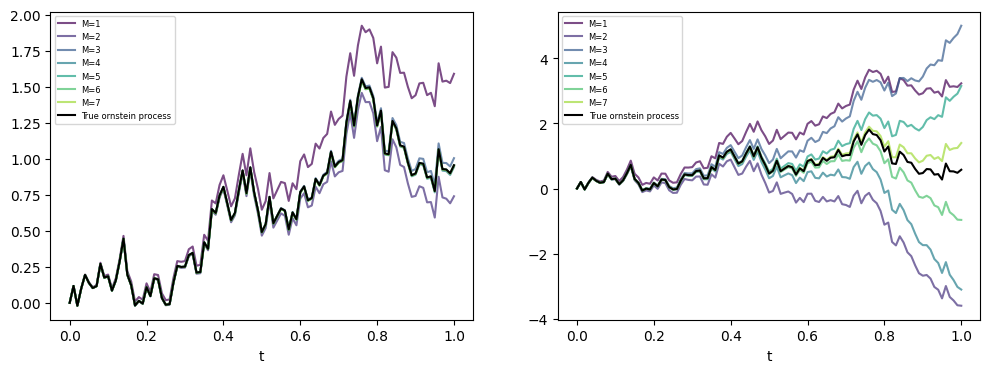

In [256]:
# Parameters
n = 100
max_sig_order = 7
x0 = 0
time_grid = np.arange(start=0, stop=n+1) / n
brownians = generate_brownian(time_grid, 1)
brownian_sig = signature(np.array([time_grid, brownians.flatten()]), max_sig_order)

(ornsteins_1, ornsteins_approx_1) = generate_naive_ornstein_sig(time_grid, brownians, brownian_sig, x0, kappa=1, etha=1.2, theta=0.25, max_sig_order=max_sig_order)
(ornsteins_2, ornsteins_approx_2) = generate_naive_ornstein_sig(time_grid, brownians, brownian_sig, x0, kappa=4, etha=2.0, theta=0.25, max_sig_order=max_sig_order)
cols = generate_blue_to_red(len(ornsteins_approx_1)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# first set of parameters
for i in range(len(ornsteins_approx_1)):
	ax1.plot(time_grid, ornsteins_approx_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax1.plot(time_grid, ornsteins_1.transpose(), label="True ornstein process", color="black")
ax1.legend(fontsize=6)
ax1.set_xlabel("t")

# and the second one...
for i in range(len(ornsteins_approx_2)):
	ax2.plot(time_grid, ornsteins_approx_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax2.plot(time_grid, ornsteins_2.transpose(), label="True ornstein process", color="black")
ax2.legend(fontsize=6)
ax2.set_xlabel("t")

if generate_new_images:
	fig.savefig("outputs/ornstein_approx_naive.png")

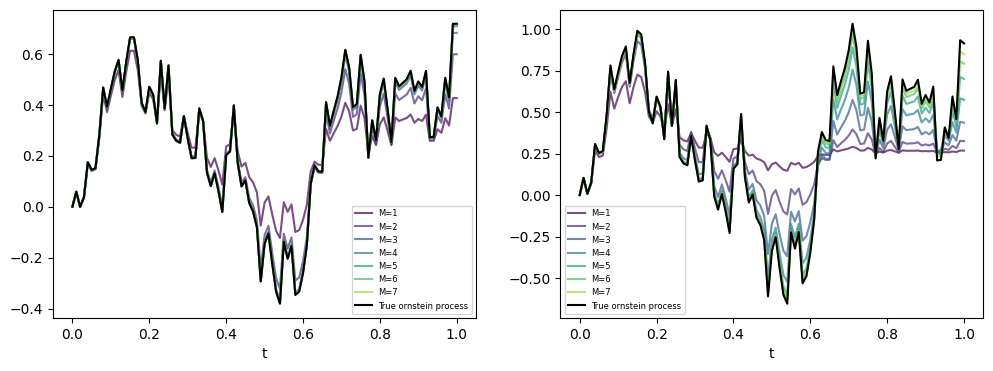

In [257]:
# Parameters
n = 100
max_sig_order = 7
x0 = 0
time_grid = np.arange(start=0, stop=n+1) / n
brownians = generate_brownian(time_grid, 1)
brownian_sig = signature(np.array([time_grid, brownians.flatten()]), max_sig_order)

(ornsteins_1, ornstein_approx_1) = generate_stable_ornstein_sig(time_grid, brownians, brownian_sig, x0, kappa=1, etha=1.2, theta=0.25, max_sig_order=max_sig_order)
(ornsteins_2, ornstein_approx_2) = generate_stable_ornstein_sig(time_grid, brownians, brownian_sig, x0, kappa=4, etha=2, theta=0.25, max_sig_order=max_sig_order)

ols = generate_blue_to_red(len(ornstein_approx_1)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# first set of parameters
for i in range(len(ornstein_approx_1)):
	ax1.plot(time_grid, ornstein_approx_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax1.plot(time_grid, ornsteins_1.transpose(), label="True ornstein process", color="black")
ax1.legend(fontsize=6)
ax1.set_xlabel("t")

# and the second one...
for i in range(len(ornstein_approx_2)):
	ax2.plot(time_grid, ornstein_approx_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax2.plot(time_grid, ornsteins_2.transpose(), label="True ornstein process", color="black")
ax2.legend(fontsize=6)
ax2.set_xlabel("t")

if generate_new_images:
	plt.savefig("outputs/ornstein_approx_stable.png")

## Mean-reverting geometric Brownian motion


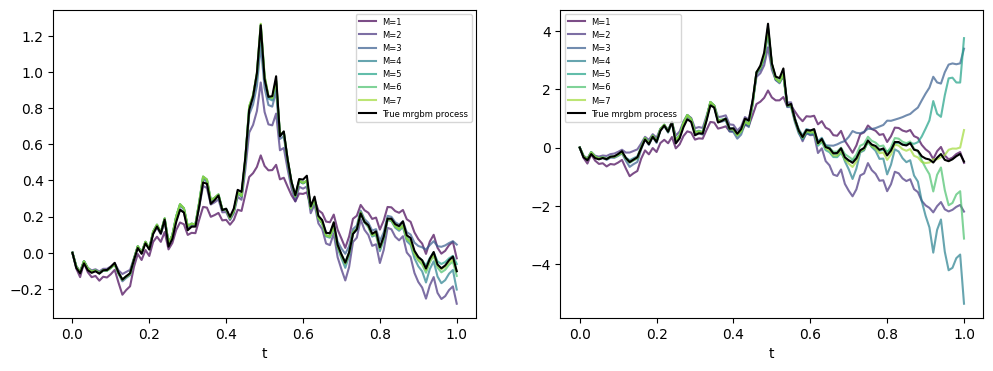

In [258]:
# Parameters
n = 100
max_sig_order = 7
x0 = 0
time_grid = np.arange(start=0, stop=n+1) / n
brownians = generate_brownian(time_grid, 1)
brownian_sig = signature(np.array([time_grid, brownians.flatten()]), max_sig_order)

(mrgbms_1, mrgbm_approx_1) = generate_naive_mrgbm_sig(time_grid, brownians, brownian_sig, x0, kappa=1, etha=0.5, theta=0.25, alpha=1.6, max_sig_order=max_sig_order)
(mrgbms_2, mrgbm_approx_2) = generate_naive_mrgbm_sig(time_grid, brownians, brownian_sig, x0, kappa=4, etha=2, theta=0.25, alpha=2, max_sig_order=max_sig_order)

ols = generate_blue_to_red(len(mrgbm_approx_1)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# first set of parameters
for i in range(len(mrgbm_approx_1)):
	ax1.plot(time_grid, mrgbm_approx_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax1.plot(time_grid, mrgbms_1.transpose(), label="True mrgbm process", color="black")
ax1.legend(fontsize=6)
ax1.set_xlabel("t")

# and the second one...
for i in range(len(mrgbm_approx_2)):
	ax2.plot(time_grid, mrgbm_approx_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax2.plot(time_grid, mrgbms_2.transpose(), label="True mrgbm process", color="black")
ax2.legend(fontsize=6)
ax2.set_xlabel("t")

if generate_new_images:
	plt.savefig("outputs/mrgbm_approx_naive.png")

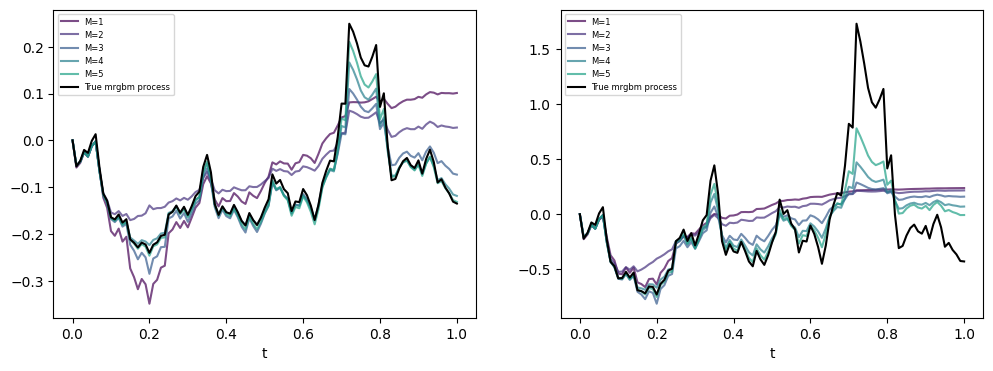

In [259]:
# Parameters
n = 100
max_sig_order = 7
x0 = 0
time_grid = np.arange(start=0, stop=n+1) / n
brownians = generate_brownian(time_grid, 1)
brownian_sig = signature(np.array([time_grid, brownians.flatten()]), max_sig_order)

(mrgbms_1, mrgbm_approx_1) = generate_stable_mrgbm_sig(time_grid, brownians, brownian_sig, x0, kappa=1, etha=0.5, theta=0.25, alpha=1.6, max_sig_order=5)
(mrgbms_2, mrgbm_approx_2) = generate_stable_mrgbm_sig(time_grid, brownians, brownian_sig, x0, kappa=4, etha=2, theta=0.25, alpha=2, max_sig_order=5)

ols = generate_blue_to_red(len(mrgbm_approx_1)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# first set of parameters
for i in range(len(mrgbm_approx_1)):
	ax1.plot(time_grid, mrgbm_approx_1[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax1.plot(time_grid, mrgbms_1.transpose(), label="True mrgbm process", color="black")
ax1.legend(fontsize=6)
ax1.set_xlabel("t")

# and the second one...
for i in range(len(mrgbm_approx_2)):
	ax2.plot(time_grid, mrgbm_approx_2[i].transpose(), color=cols[i], label=f"M={i+1}", alpha=0.7, linestyle="-")
ax2.plot(time_grid, mrgbms_2.transpose(), label="True mrgbm process", color="black")
ax2.legend(fontsize=6)
ax2.set_xlabel("t")

if generate_new_images:
	plt.savefig("outputs/mrgbm_approx_stable.png")

## Fitting signatures

In [260]:
def sig_from_flat(data: np.array, order: int):
    sig = [ np.zeros( (2,)*i ) for i in range(order+1) ]
    curr_idx = 0
    for i in range(len(sig)):
        for index in np.ndindex(sig[i].shape):
            if curr_idx >= data.shape[0]:
                continue
            sig[i][index] = data[curr_idx]
            curr_idx += 1
    return sig

In [261]:
def loss_sig(sig_data: np.array, time_grid: np.array, realizations: np.array, brownians_sigs, beta_1: float, beta_2: float, sig_order):
    """
        sig: signature whose loss will be returned
        time_grid: list of 1D increasing time values, ex: np.linspace(0,1,100). Must match the [time_grid] used in [realizations] and [brownians]
        realizations: realization of the process = f(time_grid, brownians), size = (num_simulations, num_times)
        brownians: signatures of brownian realization list of (num_simulations) lists of sig_orders of np.arrays of increasing orders w/ first dim = num_times
        beta_1, beta_2: L1 regularization parameters, the bigger, the less biased / over-fitted

        Returns a float loss
    """

    assert len(brownians_sigs) == realizations.shape[0]
    
    sig = sig_from_flat(sig_data, sig_order)

    loss_value = 0

    for i in range(len(brownians_sigs)):
        b = brownians_sigs[i]
        realization_approx = bracket_with_process(sig, b)
        loss_value =+ (( realizations[i, :] - realization_approx )**2).sum() + (beta_1 * np.abs(sig_data) + beta_2 * sig_data**2).sum()

    return loss_value / realizations.shape[0]

In [262]:
sig_order = 3
num_sim = 200
data_size = sum([2**i for i in range(sig_order+1)])
brownians = generate_brownian(time_grid, num_sim)
brownians_sig = [signature(np.array([time_grid, b.flatten()]), max_sig_order) for b in brownians]
beta_1, beta_2 = 0.1, 0.1

(ornsteins, _) = generate_naive_ornstein_sig(time_grid, brownians, brownian_sig, x0, kappa=1, etha=1.2, theta=0.25, max_sig_order=sig_order)
true_ornstein_signature = compute_ornstein_uhlenbeck_signature(x0, kappa=1, etha=1.2, theta=0.25, exp_order=sig_order )
ornstein_sig = compute_ornstein_uhlenbeck_signature(x0, kappa=1, etha=1.2, theta=0.25, exp_order=sig_order)

def loss_func(sig_data):
    return loss_sig(sig_data, time_grid, ornsteins, brownians_sig, beta_1, beta_2, sig_order)

opt_x0 = np.ones(data_size) * 0

res = scipy.optimize.minimize(loss_func, opt_x0, tol=0.001)
fitted_sig = sig_from_flat(res.x,sig_order)

Loss: 0.00, Abs Error: 4.46


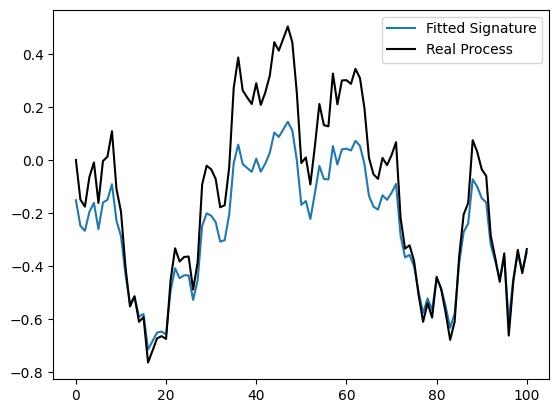

In [263]:
loss = loss_sig(res.x, time_grid, ornsteins, brownians_sig, beta_1, beta_2, sig_order)
absolute_error = sum([ np.sum(np.abs(a-b)) for (a,b) in zip(ornstein_sig, fitted_sig)])

print(f"Loss: {loss:.2f}, Abs Error: {absolute_error:.2f}")

plt.plot(bracket_with_process(fitted_sig, brownians_sig[0]), label="Fitted Signature")
plt.plot(ornsteins[0], label="Real Process", color="black")
plt.legend()
plt.show()